In [31]:
%load_ext autoreload
%autoreload 2

In [32]:
import opendatasets as od
import pandas as pd
import numpy as np
import os
from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler, MinMaxScaler

from sklearn.compose import make_column_transformer

from sklearn.impute import KNNImputer
from feature_engine import imputation
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.discretisation import EqualFrequencyDiscretiser, DecisionTreeDiscretiser
from feature_engine.encoding import OrdinalEncoder, OneHotEncoder
from feature_engine import transformation as vt
from feature_engine.creation import CyclicalTransformer, MathematicalCombination, CombineWithReferenceFeature

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from src.pipe_func import *
# from src.eda_functions import *

import warnings
warnings.filterwarnings("ignore")



In [33]:
# load dataset
os.chdir("C:/Users/benlc/OneDrive/Desktop/python_learn/song-prediction")
train = pd.read_csv(os.getcwd() + "/data/train.csv").drop('id', axis =1)
test = pd.read_csv(os.getcwd() + "/data/test.csv").drop('id', axis =1)
test = test.iloc[:,1:]
train.head()

,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
0,212990.0,0.642286,0.856520,0.707073,0.002001,10.0,NaN,-5.619088,0,0.082570,158.386236,4,0.734642,0
1,NaN,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1
2,193213.0,NaN,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0,0.052282,178.685791,3,0.425536,0
3,249893.0,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0,0.035618,128.715630,3,0.453597,0
4,165969.0,0.493017,NaN,0.740982,0.002033,10.0,0.094891,-2.684095,0,0.050746,121.928157,4,0.741311,0


In [34]:
# convert column to categorical
cat_vars = ['key','audio_mode','time_signature','song_popularity']
train[cat_vars] = train[cat_vars].astype("object")
test[['key','audio_mode','time_signature']] = test[['key','audio_mode','time_signature']].astype("object")

cont_vars = [var for var in train.columns if var not in cat_vars]

In [35]:
# split independent and dependent variables
y = train['song_popularity'].astype('int')
X = train[cont_vars + ['key','audio_mode','time_signature']]


LR roc_auc scores: [0.50122411 0.48204648 0.4948411  0.5014859  0.49916222 0.48987032
 0.49741814 0.50435806 0.50684387 0.48659098]
Average of LR roc_auc : 0.4964 
Standard deviation of LR roc_auc : 0.0076 

KNN roc_auc scores: [0.50132586 0.50158266 0.49617829 0.50900125 0.50473122 0.50791355
 0.50296945 0.5069066  0.5041356  0.51180281]
Average of KNN roc_auc : 0.5047 
Standard deviation of KNN roc_auc : 0.0043 

RF roc_auc scores: [0.54683345 0.54135014 0.54568437 0.56013466 0.54416286 0.55559684
 0.55384803 0.55813958 0.53443534 0.56041493]
Average of RF roc_auc : 0.5501 
Standard deviation of RF roc_auc : 0.0084 

SVC roc_auc scores: [0.51610042 0.50700525 0.51010499 0.50806647 0.50581641 0.51081636
 0.50357802 0.49813827 0.48974431 0.49049494]
Average of SVC roc_auc : 0.504 
Standard deviation of SVC roc_auc : 0.0082 

XGB roc_auc scores: [0.55301376 0.53254753 0.53134447 0.54337259 0.54047759 0.56555789
 0.56263282 0.53726058 0.53772426 0.55704129]
Average of XGB roc_auc : 0.546

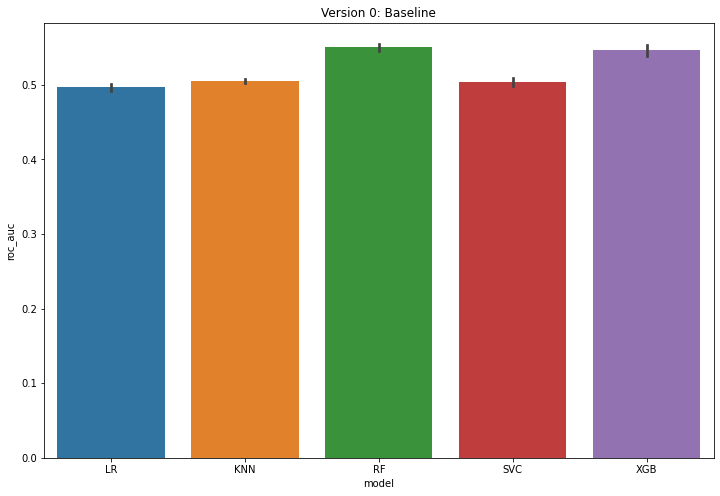

In [36]:
# baseline
# store models and scores
model_lists = {
    'LR': LogisticRegression(solver = 'liblinear'),
    'KNN': KNeighborsClassifier(n_neighbors=2, n_jobs = -1),
    'RF': RandomForestClassifier( n_jobs = -1),
    'SVC': SVC(random_state = 1),
    'XGB': XGBClassifier( random_state = 1, n_jobs = -1)
}

score_dict = {}

# initiate preprocessing class
ohe = OneHotEncoder(drop="first")
ct = make_column_transformer(
    (ohe, ['key','audio_mode','time_signature']),
    remainder='passthrough')


# loop multitple models' cross validation
for _, m in model_lists.items():

    pipe = Pipeline([
        
        # missing imputation
        ("median_imputer", imputation.MeanMedianImputer(imputation_method="median",
                                                        variables=cont_vars)),
        ("add_missing_ind_row", imputation.CategoricalImputer(imputation_method="frequent",
                                                        variables=['key'])),

        # feature transformation 
        ("one_hot_encoding", ct),

        ('model', m)
    ])

    cv = StratifiedKFold(n_splits=10, random_state=1)
    scores = cross_val_score(pipe, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    print(f"{_} roc_auc scores: {scores}")
    print(f"Average of {_} roc_auc : {scores.mean().round(4)} ")
    print(f"Standard deviation of {_} roc_auc : {scores.std().round(4)} \n")

    score_dict[_] = scores

# ovarall values in plot
score_df = pd.DataFrame(score_dict)
score_df = pd.melt(score_df, value_vars=score_df.keys(), var_name = 'model', value_name = "roc_auc")
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x="model", y="roc_auc", data=score_df).set_title("Version 0: Baseline")
plt.show()

# final_pipeline = pipe.fit(X, y)
# test_pred = final_pipeline.predict_proba(test)
# test_pred

LR roc_auc scores: [0.50122411 0.48204675 0.4948411  0.5014859  0.49916222 0.48987032
 0.49741787 0.50435806 0.50684441 0.48659098]
Average of LR roc_auc : 0.4964 
Standard deviation of LR roc_auc : 0.0076 

KNN roc_auc scores: [0.50146188 0.50532826 0.49554741 0.50884849 0.5014624  0.50975505
 0.50110678 0.50724805 0.50397803 0.51097137]
Average of KNN roc_auc : 0.5046 
Standard deviation of KNN roc_auc : 0.0045 

RF roc_auc scores: [0.5510766  0.53951688 0.53700753 0.55596466 0.55552655 0.55321167
 0.54970717 0.54384839 0.54366209 0.56531141]
Average of RF roc_auc : 0.5495 
Standard deviation of RF roc_auc : 0.0082 

SVC roc_auc scores: [0.49158887 0.50375005 0.50176659 0.50700201 0.51049825 0.51790199
 0.50710748 0.50313337 0.49134216 0.51790199]
Average of SVC roc_auc : 0.5052 
Standard deviation of SVC roc_auc : 0.0087 

XGB roc_auc scores: [0.54908073 0.5417126  0.54023493 0.55590879 0.54699998 0.55962491
 0.56422068 0.5524346  0.53091169 0.54985921]
Average of XGB roc_auc : 0.54

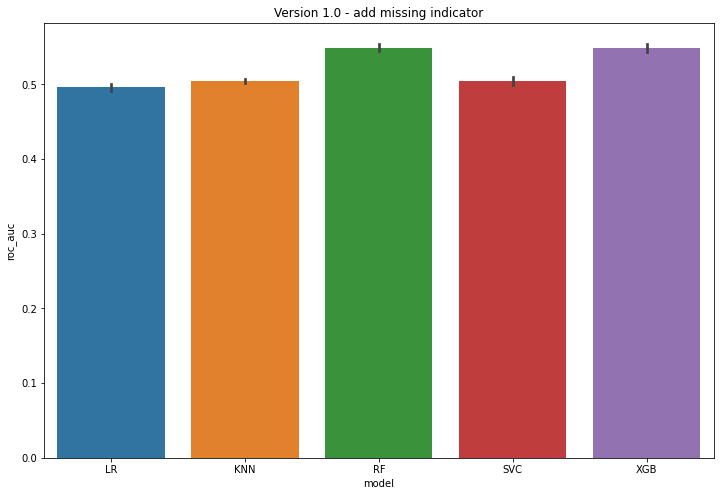

In [ ]:
# version 1 - add missing indicator in column
# store models and scores
model_lists = {
    'LR': LogisticRegression(solver = 'liblinear'),
    'KNN': KNeighborsClassifier(n_neighbors=2, n_jobs = -1),
    'RF': RandomForestClassifier( n_jobs = -1),
    'SVC': SVC(random_state = 1),
    'XGB': XGBClassifier( random_state = 1, n_jobs = -1)
}

score_dict = {}

# initiate preprocessing class
ohe = OneHotEncoder(drop="first")
ct = make_column_transformer(
    (ohe, ['key','audio_mode','time_signature']),
    remainder='passthrough')


# loop multitple models' cross validation
for _, m in model_lists.items():

    pipe = Pipeline([
        
        # missing imputation
        ("add_missing_ind_col", imputation.AddMissingIndicator(missing_only=True)),

        ("median_imputer", imputation.MeanMedianImputer(imputation_method="median",
                                                        variables=cont_vars)),
        ("add_missing_ind_row", imputation.CategoricalImputer(imputation_method="frequent",
                                                        variables=['key'])),

        # feature transformation 
        ("one_hot_encoding", ct),

        ('model', m)
    ])

    # split independent and dependent variables
    y = train['song_popularity']
    X = train[cont_vars + ['key','audio_mode','time_signature']]

    cv = StratifiedKFold(n_splits=10, random_state=1)
    scores = cross_val_score(pipe, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    print(f"{_} roc_auc scores: {scores}")
    print(f"Average of {_} roc_auc : {scores.mean().round(4)} ")
    print(f"Standard deviation of {_} roc_auc : {scores.std().round(4)} \n")

    score_dict[_] = scores

# ovarall values in plot
score_df = pd.DataFrame(score_dict)
score_df = pd.melt(score_df, value_vars=score_df.keys(), var_name = 'model', value_name = "roc_auc")
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x="model", y="roc_auc", data=score_df).set_title("Version 1.0 - add missing indicator")
plt.show()



LR roc_auc scores: [0.50122411 0.48204675 0.4948411  0.5014859  0.49916222 0.48987032
 0.49741814 0.50435806 0.50684387 0.48659098]
Average of LR roc_auc : 0.4964 
Standard deviation of LR roc_auc : 0.0076 

KNN roc_auc scores: [0.50104948 0.50314387 0.49502854 0.50693696 0.50302976 0.50814479
 0.50436076 0.50740846 0.50537769 0.50854101]
Average of KNN roc_auc : 0.5043 
Standard deviation of KNN roc_auc : 0.0039 

RF roc_auc scores: [0.54724801 0.54165255 0.53539748 0.54817361 0.55023075 0.55264775
 0.5470677  0.56247241 0.53897957 0.54746284]
Average of RF roc_auc : 0.5471 
Standard deviation of RF roc_auc : 0.0071 

SVC roc_auc scores: [0.5109036  0.51963415 0.49500547 0.50684223 0.48696737 0.50923039
 0.51753774 0.50033133 0.48673479 0.50377823]
Average of SVC roc_auc : 0.5037 
Standard deviation of SVC roc_auc : 0.0109 

XGB roc_auc scores: [0.55568734 0.54656855 0.54933834 0.55586695 0.55187972 0.56730926
 0.55818086 0.53524249 0.53527744 0.5519778 ]
Average of XGB roc_auc : 0.55

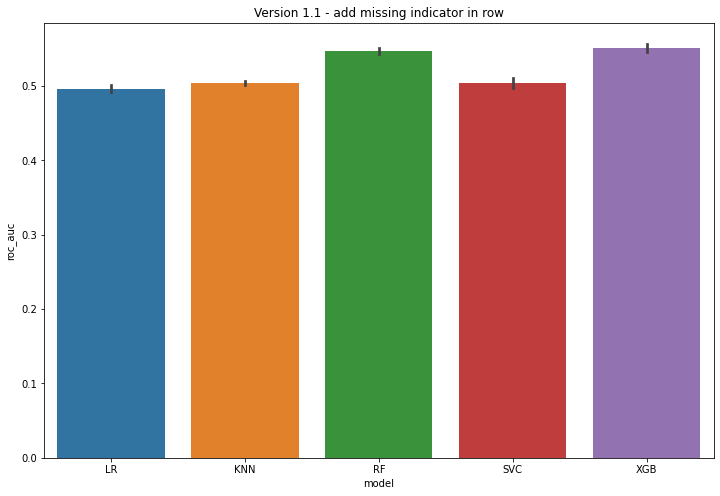

In [ ]:
# version 1.1 - add missing indicator in row
# store models and scores
model_lists = {
    'LR': LogisticRegression(solver = 'liblinear'),
    'KNN': KNeighborsClassifier(n_neighbors=2, n_jobs = -1),
    'RF': RandomForestClassifier( n_jobs = -1),
    'SVC': SVC(random_state = 1),
    'XGB': XGBClassifier( random_state = 1, n_jobs = -1)
}

score_dict = {}

# initiate preprocessing class
ohe = OneHotEncoder(drop="first")
ct = make_column_transformer(
    (ohe, ['key','audio_mode','time_signature']),
    remainder='passthrough')


# loop multitple models' cross validation
for _, m in model_lists.items():

    pipe = Pipeline([
        
        # missing imputation

        ("median_imputer", imputation.MeanMedianImputer(imputation_method="median",
                                                        variables=cont_vars)),

        ("add_missing_ind_row", imputation.CategoricalImputer(
                                                    variables=['key'])),

        # feature transformation 
        ("one_hot_encoding", ct),

        ('model', m)
    ])

    # split independent and dependent variables
    y = train['song_popularity']
    X = train[cont_vars + ['key','audio_mode','time_signature']]

    cv = StratifiedKFold(n_splits=10, random_state=1)
    scores = cross_val_score(pipe, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    print(f"{_} roc_auc scores: {scores}")
    print(f"Average of {_} roc_auc : {scores.mean().round(4)} ")
    print(f"Standard deviation of {_} roc_auc : {scores.std().round(4)} \n")

    score_dict[_] = scores

# ovarall values in plot
score_df = pd.DataFrame(score_dict)
score_df = pd.melt(score_df, value_vars=score_df.keys(), var_name = 'model', value_name = "roc_auc")
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x="model", y="roc_auc", data=score_df).set_title("Version 1.1 - add missing indicator in row")
plt.show()

LR roc_auc scores: [0.50193933 0.48179953 0.4946152  0.50254875 0.50064351 0.49056995
 0.4988889  0.50448325 0.50670222 0.48717648]
Average of LR roc_auc : 0.4969 
Standard deviation of LR roc_auc : 0.0077 

KNN roc_auc scores: [0.49908546 0.50102546 0.49764126 0.5065104  0.50077707 0.50801784
 0.50475172 0.5060212  0.50544137 0.50829575]
Average of KNN roc_auc : 0.5038 
Standard deviation of KNN roc_auc : 0.0036 

RF roc_auc scores: [0.54779387 0.54059295 0.54547143 0.54399524 0.53146238 0.55083675
 0.54469939 0.55339649 0.54164764 0.54356738]
Average of RF roc_auc : 0.5443 
Standard deviation of RF roc_auc : 0.0057 

SVC roc_auc scores: [0.48414788 0.48604497 0.50437405 0.49555524 0.49033143 0.50695288
 0.49452355 0.49989558 0.5046384  0.49006404]
Average of SVC roc_auc : 0.4957 
Standard deviation of SVC roc_auc : 0.0077 

XGB roc_auc scores: [0.54944427 0.54559396 0.5461826  0.55089401 0.54021182 0.55318172
 0.5674845  0.54118059 0.54875486 0.5570417 ]
Average of XGB roc_auc : 0.55

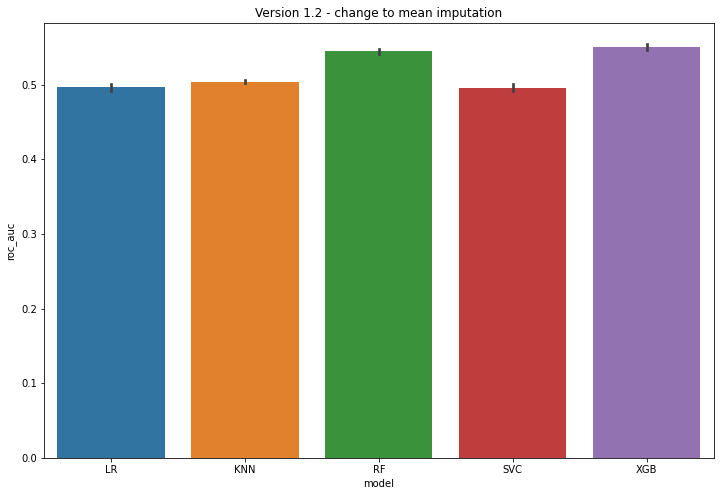

In [ ]:
# version 1.2 - change to mean imputation
# store models and scores
model_lists = {
    'LR': LogisticRegression(solver = 'liblinear'),
    'KNN': KNeighborsClassifier(n_neighbors=2, n_jobs = -1),
    'RF': RandomForestClassifier( n_jobs = -1),
    'SVC': SVC(random_state = 1),
    'XGB': XGBClassifier( random_state = 1, n_jobs = -1)
}

score_dict = {}

# initiate preprocessing class
ohe = OneHotEncoder(drop="first")
ct = make_column_transformer(
    (ohe, ['key','audio_mode','time_signature']),
    remainder='passthrough')


# loop multitple models' cross validation
for _, m in model_lists.items():

    pipe = Pipeline([
        
        # missing imputation

        ("median_imputer", imputation.MeanMedianImputer(imputation_method="mean",
                                                        variables=cont_vars)),

        ("add_missing_ind_row", imputation.CategoricalImputer(imputation_method="frequent",
                                                    variables=['key'])),

        # feature transformation 
        ("one_hot_encoding", ct),

        ('model', m)
    ])

    # split independent and dependent variables
    y = train['song_popularity']
    X = train[cont_vars + ['key','audio_mode','time_signature']]

    cv = StratifiedKFold(n_splits=10, random_state=1)
    scores = cross_val_score(pipe, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    print(f"{_} roc_auc scores: {scores}")
    print(f"Average of {_} roc_auc : {scores.mean().round(4)} ")
    print(f"Standard deviation of {_} roc_auc : {scores.std().round(4)} \n")

    score_dict[_] = scores

# ovarall values in plot
score_df = pd.DataFrame(score_dict)
score_df = pd.melt(score_df, value_vars=score_df.keys(), var_name = 'model', value_name = "roc_auc")
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x="model", y="roc_auc", data=score_df).set_title("Version 1.2 - change to mean imputation")
plt.show()

LR roc_auc scores: [0.5579276  0.53562675 0.53160371 0.54914496 0.53489848 0.54708065
 0.52221526 0.54225095 0.53407311 0.56728012]
Average of LR roc_auc : 0.5422 
Standard deviation of LR roc_auc : 0.0127 

KNN roc_auc scores: [0.51286047 0.49563823 0.51197643 0.51214552 0.50555806 0.51632748
 0.52940126 0.49744781 0.50784043 0.52440522]
Average of KNN roc_auc : 0.5114 
Standard deviation of KNN roc_auc : 0.0101 

RF roc_auc scores: [0.54760292 0.53414463 0.54493987 0.54197467 0.5411153  0.55554544
 0.55743037 0.5568214  0.53558556 0.55510537]
Average of RF roc_auc : 0.547 
Standard deviation of RF roc_auc : 0.0084 

SVC roc_auc scores: [0.48412278 0.50642309 0.49339204 0.50431953 0.50447273 0.48826033
 0.49988614 0.50853912 0.51231276 0.51698732]
Average of SVC roc_auc : 0.5019 
Standard deviation of SVC roc_auc : 0.01 

XGB roc_auc scores: [0.54589111 0.5514473  0.54486146 0.55002023 0.5501409  0.55049705
 0.56347383 0.53536715 0.54827108 0.5595124 ]
Average of XGB roc_auc : 0.5499 

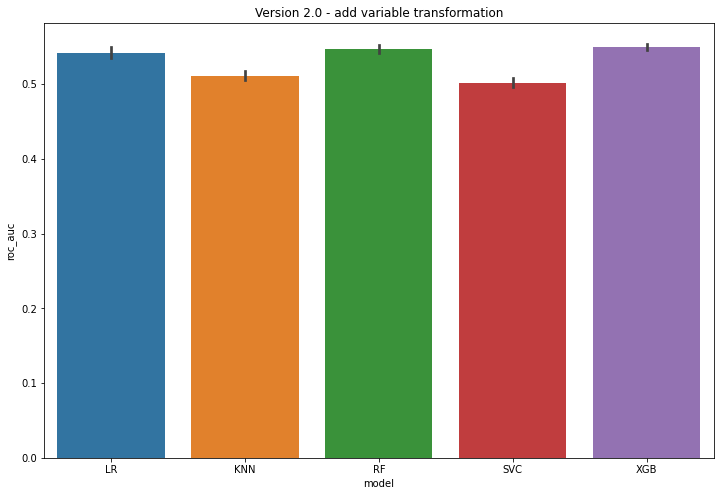

In [37]:
# version 2.0 - add variable transformation
# store models and scores
model_lists = {
    'LR': LogisticRegression(solver = 'liblinear'),
    'KNN': KNeighborsClassifier(n_neighbors=2, n_jobs = -1),
    'RF': RandomForestClassifier( n_jobs = -1),
    'SVC': SVC(random_state = 1),
    'XGB': XGBClassifier( random_state = 1, n_jobs = -1)
}

score_dict = {}

# initiate preprocessing class
ohe = OneHotEncoder(drop="first")
lt = vt.LogTransformer()
rt = vt.ReciprocalTransformer()
pt = vt.PowerTransformer()
box_t = vt.BoxCoxTransformer()
yt = vt.YeoJohnsonTransformer()

ct = make_column_transformer(
    (lt, ['liveness']),
    (rt, ['tempo']),
    (pt, ['danceability', 'audio_valence' ]),
    (box_t, ['speechiness']),
    (yt, ['song_duration_ms', 'loudness']),
    (ohe, ['key','audio_mode','time_signature']),
    remainder='passthrough')


# loop multitple models' cross validation
for _, m in model_lists.items():

    pipe = Pipeline([
        
        # missing imputation

        ("median_imputer", imputation.MeanMedianImputer(imputation_method="mean",
                                                        variables=cont_vars)),

        ("add_missing_ind_row", imputation.CategoricalImputer(imputation_method="frequent",
                                                    variables=['key'])),

        # feature transformation 
        ("one_hot_encoding", ct),

        ('model', m)
    ])

    cv = StratifiedKFold(n_splits=10, random_state=1)
    scores = cross_val_score(pipe, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    print(f"{_} roc_auc scores: {scores}")
    print(f"Average of {_} roc_auc : {scores.mean().round(4)} ")
    print(f"Standard deviation of {_} roc_auc : {scores.std().round(4)} \n")

    score_dict[_] = scores

# ovarall values in plot
score_df = pd.DataFrame(score_dict)
score_df = pd.melt(score_df, value_vars=score_df.keys(), var_name = 'model', value_name = "roc_auc")
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x="model", y="roc_auc", data=score_df).set_title("Version 2.0 - add variable transformation")
plt.show()

LR roc_auc scores: [0.55760885 0.52737743 0.52774556 0.53821828 0.5297817  0.5385016
 0.51327277 0.53627319 0.52905212 0.55190036]
Average of LR roc_auc : 0.535 
Standard deviation of LR roc_auc : 0.0121 

KNN roc_auc scores: [0.51046611 0.497012   0.51879073 0.51823367 0.50477128 0.5133239
 0.52793737 0.4920136  0.50981481 0.5181768 ]
Average of KNN roc_auc : 0.5111 
Standard deviation of KNN roc_auc : 0.0103 

RF roc_auc scores: [0.54900866 0.53801991 0.53810735 0.54097606 0.53661693 0.55339244
 0.54508604 0.54509832 0.53642941 0.56596301]
Average of RF roc_auc : 0.5449 
Standard deviation of RF roc_auc : 0.0088 

SVC roc_auc scores: [0.5039522  0.47829549 0.48374547 0.48564768 0.49936485 0.49232078
 0.5028131  0.5056923  0.49283154 0.4969322 ]
Average of SVC roc_auc : 0.4942 
Standard deviation of SVC roc_auc : 0.0088 

XGB roc_auc scores: [0.53250245 0.55138428 0.52895213 0.5453435  0.54318263 0.5524829
 0.55871671 0.53783124 0.54375355 0.57653182]
Average of XGB roc_auc : 0.5471 


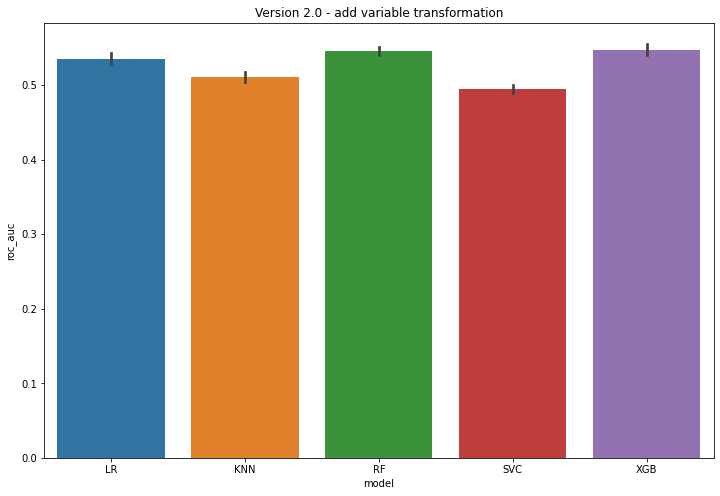

In [44]:
# version 2.1 - add decision tree discretisation
# store models and scores
model_lists = {
    'LR': LogisticRegression(solver = 'liblinear'),
    'KNN': KNeighborsClassifier(n_neighbors=2, n_jobs = -1),
    'RF': RandomForestClassifier( n_jobs = -1),
    'SVC': SVC(random_state = 1),
    'XGB': XGBClassifier( random_state = 1, n_jobs = -1)
}

score_dict = {}

# initiate preprocessing class
ohe = OneHotEncoder(drop="first")
lt = vt.LogTransformer()
rt = vt.ReciprocalTransformer()
pt = vt.PowerTransformer()
box_t = vt.BoxCoxTransformer()
yt = vt.YeoJohnsonTransformer()

eq_disc = EqualFrequencyDiscretiser(q=10, return_object = False)
treeDisc = DecisionTreeDiscretiser(
    cv =10, scoring="roc_auc",
    # variables=[],
    regression =False,
    param_grid = {'max_depth':[1, 2, 3],
                'min_samples_leaf':[10,4]}
)

ct_linear_trans = make_column_transformer(
    (lt, ['liveness']),
    (rt, ['tempo']),
    (pt, ['danceability', 'audio_valence' ]),
    (box_t, ['speechiness']),
    (yt, ['song_duration_ms', 'loudness']),
    (treeDisc, ['acousticness','energy','instrumentalness']),
    (ohe, ['key','audio_mode','time_signature']),
    remainder='passthrough')



# loop multitple models' cross validation
for _, m in model_lists.items():


    pipe = Pipeline([
        
        # missing imputation

        ("median_imputer", imputation.MeanMedianImputer(imputation_method="mean",
                                                        variables=cont_vars)),

        ("add_missing_ind_row", imputation.CategoricalImputer(imputation_method="frequent",
                                                    variables=['key'])),

        # feature transformation 
        ("linear_trans_encoding", ct_linear_trans),

        ('model', m)
    ])

    cv = StratifiedKFold(n_splits=10, random_state=1)
    scores = cross_val_score(pipe, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    print(f"{_} roc_auc scores: {scores}")
    print(f"Average of {_} roc_auc : {scores.mean().round(4)} ")
    print(f"Standard deviation of {_} roc_auc : {scores.std().round(4)} \n")

    score_dict[_] = scores

# ovarall values in plot
score_df = pd.DataFrame(score_dict)
score_df = pd.melt(score_df, value_vars=score_df.keys(), var_name = 'model', value_name = "roc_auc")
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x="model", y="roc_auc", data=score_df).set_title("Version 2.0 - add variable transformation")
plt.show()

LR roc_auc scores: [0.55504728 0.55073518 0.53066771 0.56012859 0.54775438 0.55895145
 0.55411717 0.55021672 0.54415099 0.57408999]
Average of LR roc_auc : 0.5526 
Standard deviation of LR roc_auc : 0.0107 

KNN roc_auc scores: [0.50840344 0.49861085 0.50002038 0.51405152 0.50816745 0.51988244
 0.51389456 0.50928732 0.50300143 0.50681122]
Average of KNN roc_auc : 0.5082 
Standard deviation of KNN roc_auc : 0.0063 

RF roc_auc scores: [0.53888613 0.53508804 0.53295628 0.54943388 0.5451373  0.55158225
 0.55019783 0.55205726 0.53168781 0.54042336]
Average of RF roc_auc : 0.5427 
Standard deviation of RF roc_auc : 0.0075 

SVC roc_auc scores: [0.48092264 0.48338867 0.48829616 0.49706746 0.50461142 0.48988489
 0.48527752 0.50832947 0.50140601 0.50881056]
Average of SVC roc_auc : 0.4948 
Standard deviation of SVC roc_auc : 0.01 

XGB roc_auc scores: [0.53892878 0.53881502 0.54794474 0.55302901 0.52689575 0.55557431
 0.55674328 0.54928558 0.53494192 0.5582927 ]
Average of XGB roc_auc : 0.546 

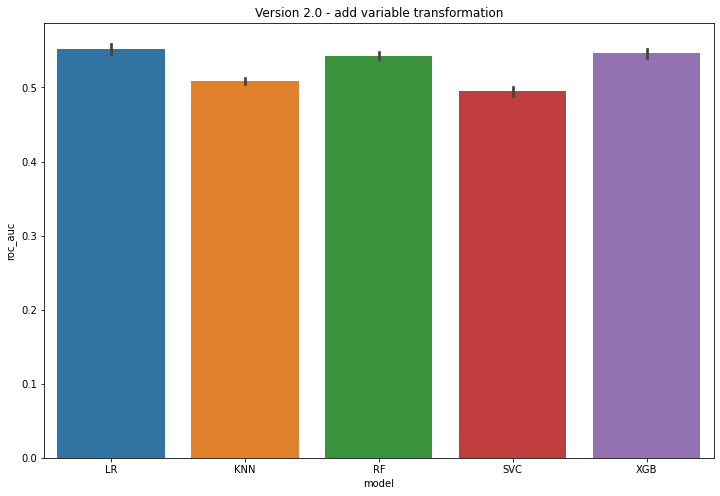

In [52]:
# version 2.1 - add cossin fe
# store models and scores
model_lists = {
    'LR': LogisticRegression(solver = 'liblinear'),
    'KNN': KNeighborsClassifier(n_neighbors=2, n_jobs = -1),
    'RF': RandomForestClassifier( n_jobs = -1),
    'SVC': SVC(random_state = 1),
    'XGB': XGBClassifier( random_state = 1, n_jobs = -1)
}

score_dict = {}

# initiate preprocessing class
ohe = OneHotEncoder(drop="first")
lt = vt.LogTransformer()
rt = vt.ReciprocalTransformer()
pt = vt.PowerTransformer()
box_t = vt.BoxCoxTransformer()
yt = vt.YeoJohnsonTransformer()

eq_disc = EqualFrequencyDiscretiser(q=10, return_object = False)
treeDisc = DecisionTreeDiscretiser(
    cv =10, scoring="roc_auc",
    # variables=[],
    regression =False,
    param_grid = {'max_depth':[1, 2, 3],
                'min_samples_leaf':[10,4]}
)
cy = CyclicalTransformer(variables =cont_vars)

ct_linear_trans = make_column_transformer(
    (lt, ['liveness']),
    (rt, ['tempo']),
    (pt, ['danceability', 'audio_valence' ]),
    (box_t, ['speechiness']),
    (yt, ['song_duration_ms', 'loudness']),
    # (treeDisc, ['acousticness','energy','instrumentalness']),
    (ohe, ['key','audio_mode','time_signature']),
    remainder='passthrough')



# loop multitple models' cross validation
for _, m in model_lists.items():


    pipe = Pipeline([
        
        # missing imputation

        ("median_imputer", imputation.MeanMedianImputer(imputation_method="mean",
                                                        variables=cont_vars)),

        ("add_missing_ind_row", imputation.CategoricalImputer(imputation_method="frequent",
                                                    variables=['key'])),

        # feature transformation 
        ("cos_sin_eng", cy),
        
        ("linear_trans_encoding", ct_linear_trans),

        ('model', m)
    ])

    cv = StratifiedKFold(n_splits=10, random_state=1)
    scores = cross_val_score(pipe, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    print(f"{_} roc_auc scores: {scores}")
    print(f"Average of {_} roc_auc : {scores.mean().round(4)} ")
    print(f"Standard deviation of {_} roc_auc : {scores.std().round(4)} \n")

    score_dict[_] = scores

# ovarall values in plot
score_df = pd.DataFrame(score_dict)
score_df = pd.melt(score_df, value_vars=score_df.keys(), var_name = 'model', value_name = "roc_auc")
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x="model", y="roc_auc", data=score_df).set_title("Version 2.0 - add variable transformation")
plt.show()

LR roc_auc scores: [0.56335734 0.54930555 0.53383492 0.55835916 0.5424633  0.55084107
 0.54799802 0.55072154 0.5395474  0.57765938]
Average of LR roc_auc : 0.5514 
Standard deviation of LR roc_auc : 0.0119 

KNN roc_auc scores: [0.50013117 0.50544755 0.49842058 0.49830844 0.49530116 0.5045383
 0.51871009 0.51569868 0.50661844 0.50440258]
Average of KNN roc_auc : 0.5048 
Standard deviation of KNN roc_auc : 0.0071 

RF roc_auc scores: [0.55443341 0.53901676 0.54288557 0.55073464 0.53227371 0.55968845
 0.5439976  0.54906015 0.54052845 0.54272218]
Average of RF roc_auc : 0.5455 
Standard deviation of RF roc_auc : 0.0076 

XGB roc_auc scores: [0.53787443 0.55103638 0.53516631 0.54763409 0.54773684 0.55502672
 0.56284543 0.55167547 0.54200623 0.54617488]
Average of XGB roc_auc : 0.5477 
Standard deviation of XGB roc_auc : 0.0077 



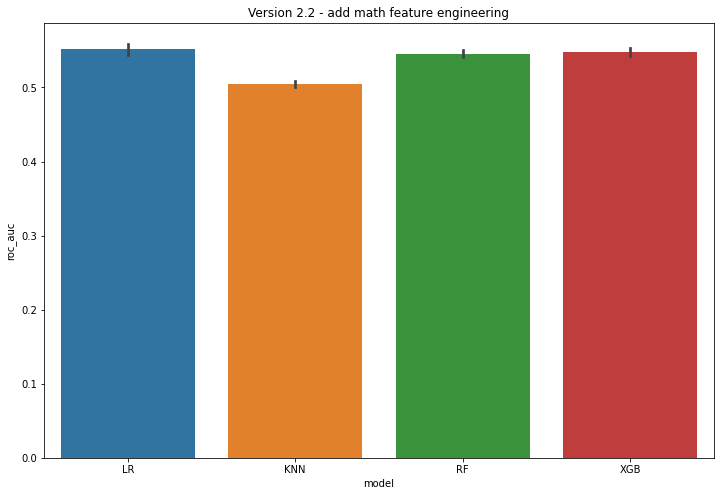

In [8]:
# version 2.2 - add math feature engineering
# store models and scores
model_lists = {
    'LR': LogisticRegression(solver = 'liblinear'),
    'KNN': KNeighborsClassifier(n_neighbors=2, n_jobs = -1),
    'RF': RandomForestClassifier( n_jobs = -1),
    # 'SVC': SVC(random_state = 1),
    'XGB': XGBClassifier( random_state = 1, n_jobs = -1)
}

score_dict = {}

# initiate preprocessing class
ohe = dummify(drop_first=True)
lt = vt.LogTransformer(['liveness'])
rt = vt.ReciprocalTransformer(['tempo'])
pt = vt.PowerTransformer(['danceability', 'audio_valence' ])
box_t = vt.BoxCoxTransformer(['speechiness'])
yt = vt.YeoJohnsonTransformer(['song_duration_ms', 'loudness'])


math_combinations = MathematicalCombination(
    variables_to_combine = ['acousticness', 'instrumentalness', 'speechiness'],
    math_operations = ['sum', 'prod', 'mean', 'std'])

ct_linear_trans = Pipeline([
    ('log_transformation', lt),
    ('reciprocal_transformation',rt),
    ('power_transformation',pt),
    ('boxcox_transformation',box_t),
    ('yeojohnson_transformation',yt),
])



numeric_transformer = Pipeline(steps=[

    ('fs', feat_sel(dtype='numeric')),

    # missing imputation
    ("median_imputer", imputation.MeanMedianImputer(imputation_method="mean",
                                                variables=cont_vars)),

    # normalised feature transformation 
    ("linear_trans", ct_linear_trans),

    # scaling  
    ("st_scaler", df_scaler(method = "standard")),

])

category_transformer = Pipeline(steps=[
    ('fs', feat_sel(dtype='category')),

    # missing imputation
    ("add_missing_ind_row", imputation.CategoricalImputer(imputation_method="frequent",
                                                            return_object=True,
                                                            variables=['key'])),
    # normalised feature transformation 
    ("ohe_encoding", ohe),

])

preprocessing_pipe = FeatureUnion_df(transformer_list=[
    ('num_pipe', numeric_transformer),
    ('cat_pipe', category_transformer),
])



# loop multitple models' cross validation
for _, m in model_lists.items():


    final_pipe = Pipeline(steps =[
    ("preprocess", preprocessing_pipe),
    # feature enggineering
    ("math_combinations", math_combinations),
    # modelling
    ('model', m)


])

    cv = StratifiedKFold(n_splits=10, random_state=1)
    scores = cross_val_score(final_pipe, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    print(f"{_} roc_auc scores: {scores}")
    print(f"Average of {_} roc_auc : {scores.mean().round(4)} ")
    print(f"Standard deviation of {_} roc_auc : {scores.std().round(4)} \n")

    score_dict[_] = scores

# ovarall values in plot
score_df = pd.DataFrame(score_dict)
score_df = pd.melt(score_df, value_vars=score_df.keys(), var_name = 'model', value_name = "roc_auc")
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x="model", y="roc_auc", data=score_df).set_title("Version 2.2 - add math feature engineering")
plt.show()

In [44]:
model_lists = {
    'LR': LogisticRegression(solver = 'liblinear'),
    'KNN': KNeighborsClassifier(n_neighbors=2, n_jobs = -1),
    'RF': RandomForestClassifier( n_jobs = -1),
    'SVC': SVC(random_state = 1),
    'XGB': XGBClassifier( random_state = 1, n_jobs = -1)
}

score_dict = {}

# initiate preprocessing class
ohe = dummify(drop_first=True)
lt = vt.LogTransformer(['liveness'])
rt = vt.ReciprocalTransformer(['tempo'])
pt = vt.PowerTransformer(['danceability', 'audio_valence' ])
box_t = vt.BoxCoxTransformer(['speechiness'])
yt = vt.YeoJohnsonTransformer(['song_duration_ms', 'loudness'])


math_combinations = MathematicalCombination(
    variables_to_combine = ['acousticness', 'instrumentalness', 'speechiness'],
    math_operations = ['sum', 'prod', 'mean', 'std'])

interact_fe = CombineWithReferenceFeature(
    variables_to_combine = cont_vars,
    reference_variables=cont_vars,
    operations=['sub', 'div','add', 'mul'])

ct_linear_trans = Pipeline([
    ('log_transformation', lt),
    ('reciprocal_transformation',rt),
    ('power_transformation',pt),
    ('boxcox_transformation',box_t),
    ('yeojohnson_transformation',yt),
])



numeric_transformer = Pipeline(steps=[

    ('fs', feat_sel(dtype='numeric')),

    # missing imputation
    ("median_imputer", imputation.MeanMedianImputer(imputation_method="mean",
                                                variables=cont_vars)),

    # normalised feature transformation 
    ("linear_trans", ct_linear_trans),

    # scaling  
    ("st_scaler", df_scaler(method = "standard")),

])

category_transformer = Pipeline(steps=[
    ('fs', feat_sel(dtype='category')),

    # missing imputation
    ("add_missing_ind_row", imputation.CategoricalImputer(imputation_method="frequent",
                                                            return_object=True,
                                                            variables=['key'])),
    # normalised feature transformation 
    ("ohe_encoding", ohe),

])

preprocessing_pipe = FeatureUnion_df(transformer_list=[
    ('num_pipe', numeric_transformer),
    ('cat_pipe', category_transformer),
])

final_pipe = Pipeline(steps =[
    ("preprocess", preprocessing_pipe),
    # feature enggineering
    ("math_combinations", math_combinations),
    ("interact_fe", interact_fe)
])

In [54]:
from sklearn.cluster import KMeans

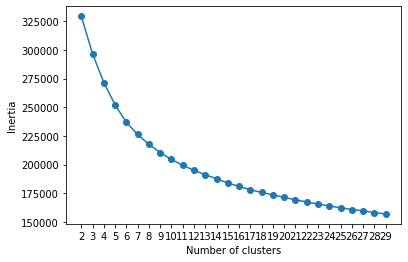

Wall time: 2min 29s


In [63]:
%%time
X_pred = numeric_transformer.fit_transform(X)

inertia = {}
for i in range(2,30):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit_predict(X_pred[cont_vars])
    inertia.update({i:kmeans.inertia_})

inertia_df = pd.Series(inertia)
plt.plot(inertia_df,marker="o")
plt.xticks(inertia_df.index)
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.show()

In [62]:
X_pred

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence,song_popularity
0,0.498145,1.294390e+00,1.399848,1.146636e-01,-2.425337e-01,0.319246,0.354430,0.453796,-1.405563,0.669562,0
1,0.050419,-7.837456e-01,0.865012,7.512426e-01,-2.495988e-01,1.755075,0.507071,0.962532,0.388418,0.590145,1
2,0.051508,-1.963837e-16,-2.400617,4.934772e-01,-2.755183e-01,0.041963,0.628377,-0.242602,-1.781984,-0.527168,0
3,1.284547,7.509048e-01,0.158838,-6.503297e-01,-2.523217e-01,-1.027764,-0.380028,-0.989996,-0.641775,-0.403482,0
4,-0.598841,7.663190e-01,0.086204,2.826813e-01,-2.423106e-01,-1.026113,1.932288,-0.294828,-0.414805,0.692246,0
...,...,...,...,...,...,...,...,...,...,...,...
39995,1.032935,-1.963837e-16,0.935320,-8.557186e-01,-2.361288e-01,0.076952,-0.625891,0.377902,-1.600055,-1.872690,0
39996,0.003043,-7.390897e-01,0.586148,1.019505e+00,-2.479867e-01,-0.554336,-0.354087,1.324317,0.022426,0.856914,0
39997,-0.725512,2.126274e+00,-0.811091,-1.938700e+00,4.874433e-17,-0.745845,-1.779835,-1.282270,0.552426,-1.874158,1
39998,0.067771,-1.963837e-16,-1.080351,5.501161e-16,-2.542113e-01,1.385388,0.758868,-0.183953,-0.966587,0.798594,0


In [45]:
import h2o
from  h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.automl import H2OAutoML

In [46]:
train_transformed = final_pipe.fit_transform(X)
train_transformed['song_popularity'] = train['song_popularity'].astype('object')
train_transformed

,song_duration_ms,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,audio_valence,...,acousticness_mul_audio_valence,danceability_mul_audio_valence,energy_mul_audio_valence,instrumentalness_mul_audio_valence,liveness_mul_audio_valence,loudness_mul_audio_valence,speechiness_mul_audio_valence,tempo_mul_audio_valence,audio_valence_mul_audio_valence,song_popularity
0,0.498145,1.294390e+00,1.399848,1.146636e-01,-2.425337e-01,0.319246,0.354430,0.453796,-1.405563,0.669562,...,8.666749e-01,0.937285,7.677443e-02,-1.623914e-01,0.213755,0.237313,0.303844,-0.941112,0.448314,0
1,0.050419,-7.837456e-01,0.865012,7.512426e-01,-2.495988e-01,1.755075,0.507071,0.962532,0.388418,0.590145,...,-4.625236e-01,0.510483,4.433421e-01,-1.472995e-01,1.035749,0.299245,0.568034,0.229223,0.348271,1
2,0.051508,-1.963837e-16,-2.400617,4.934772e-01,-2.755183e-01,0.041963,0.628377,-0.242602,-1.781984,-0.527168,...,1.035272e-16,1.265529,-2.601454e-01,1.452444e-01,-0.022122,-0.331260,0.127892,0.939405,0.277906,0
3,1.284547,7.509048e-01,0.158838,-6.503297e-01,-2.523217e-01,-1.027764,-0.380028,-0.989996,-0.641775,-0.403482,...,-3.029766e-01,-0.064088,2.623964e-01,1.018073e-01,0.414684,0.153334,0.399446,0.258945,0.162798,0
4,-0.598841,7.663190e-01,0.086204,2.826813e-01,-2.423106e-01,-1.026113,1.932288,-0.294828,-0.414805,0.692246,...,5.304814e-01,0.059674,1.956851e-01,-1.677386e-01,-0.710323,1.337619,-0.204093,-0.287147,0.479205,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,1.032935,-1.963837e-16,0.935320,-8.557186e-01,-2.361288e-01,0.076952,-0.625891,0.377902,-1.600055,-1.872690,...,3.677659e-16,-1.751564,1.602496e+00,4.421961e-01,-0.144107,1.172099,-0.707693,2.996406,3.506967,0
39996,0.003043,-7.390897e-01,0.586148,1.019505e+00,-2.479867e-01,-0.554336,-0.354087,1.324317,0.022426,0.856914,...,-6.333363e-01,0.502279,8.736284e-01,-2.125032e-01,-0.475018,-0.303422,1.134825,0.019217,0.734302,0
39997,-0.725512,2.126274e+00,-0.811091,-1.938700e+00,4.874433e-17,-0.745845,-1.779835,-1.282270,0.552426,-1.874158,...,-3.984972e+00,1.520113,3.633430e+00,-9.135457e-17,1.397831,3.335693,2.403176,-1.035333,3.512468,1
39998,0.067771,-1.963837e-16,-1.080351,5.501161e-16,-2.542113e-01,1.385388,0.758868,-0.183953,-0.966587,0.798594,...,-1.568309e-16,-0.862762,4.393195e-16,-2.030116e-01,1.106363,0.606028,-0.146904,-0.771910,0.637753,0


In [47]:
h2o.init()

# change h2o format
train_hf = h2o.H2OFrame(train_transformed)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,21 hours 26 mins
H2O_cluster_timezone:,Asia/Singapore
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.7
H2O_cluster_version_age:,1 month and 3 days
H2O_cluster_name:,H2O_from_python_benlc_1trdtp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.052 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [52]:
# initial h2o instance
# h2o.init()

# change h2o format
train_hf = h2o.H2OFrame(train_transformed)
train_hf["song_popularity"]= train_hf["song_popularity"].asfactor()

# split train and test
song_train, song_test = train_hf.split_frame(
    ratios = [0.8],
    destination_frames = ['song_train', 'song_test'],
    seed = 123
)

# filter x and y columns
y_var = "song_popularity"
ignore_fields = [y_var]
x_var = [i for i in train_transformed.columns if i not in ignore_fields]

# cross validation of models
m_10cv = H2OAutoML(max_runtime_secs = 120, seed = 1, nfolds=10, project_name = "h2o_10folds")
m_10cv.train(x_var, y_var, song_train)

# Show comparison of all models results
m_10cv.leaderboard.head()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |█
23:17:35.674: AutoML: XGBoost is not available; skipping it.
23:17:35.706: Step 'best_of_family_xgboost' not defined in provider 'StackedEnsemble': skipping it.
23:17:35.706: Step 'all_xgboost' not defined in provider 'StackedEnsemble': skipping it.
23:17:35.739: _train param, Dropping bad and constant columns: [danceability_div_danceability, liveness_sub_liveness, loudness_div_loudness, audio_valence_div_audio_valence, acousticness_sub_acousticness, song_duration_ms_sub_song_duration_ms, song_duration_ms_div_song_duration_ms, speechiness_sub_speechiness, tempo_sub_tempo, energy_div_energy, energy_sub_energy, audio_valence_sub_audio_valence, danceability_sub_danceability, loudness_sub_loudness, tempo_div_tempo, liveness_div_liveness, acousticness_div_acousticness, speechiness_div_speechiness, instrumentalness_sub_instrumentalness, instrumentalness_div_instrumentalness]

██

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_1_AutoML_1_20220124_231735,0.557591,0.651337,0.406798,0.498684,0.479089,0.229527
GLM_1_AutoML_1_20220124_231735,0.552716,0.652708,0.402258,0.4947,0.479733,0.230144
GBM_1_AutoML_1_20220124_231735,0.549295,0.652516,0.401997,0.499002,0.479641,0.230055
GBM_2_AutoML_1_20220124_231735,0.527667,0.65539,0.379815,0.498563,0.481017,0.231378
DRF_1_AutoML_1_20220124_231735,0.510069,8.0898,0.370628,0.5,0.596973,0.356377


In [53]:
h2o.shutdown()

H2O session _sid_861f closed.


In [ ]:
# version 2.3 - add math & interaction of feature engineering
# store models and scores
model_lists = {
    'LR': LogisticRegression(solver = 'liblinear'),
    'KNN': KNeighborsClassifier(n_neighbors=2, n_jobs = -1),
    'RF': RandomForestClassifier( n_jobs = -1),
    'SVC': SVC(random_state = 1),
    'XGB': XGBClassifier( random_state = 1, n_jobs = -1)
}

score_dict = {}

# initiate preprocessing class
ohe = dummify(drop_first=True)
lt = vt.LogTransformer(['liveness'])
rt = vt.ReciprocalTransformer(['tempo'])
pt = vt.PowerTransformer(['danceability', 'audio_valence' ])
box_t = vt.BoxCoxTransformer(['speechiness'])
yt = vt.YeoJohnsonTransformer(['song_duration_ms', 'loudness'])


math_combinations = MathematicalCombination(
    variables_to_combine = ['acousticness', 'instrumentalness', 'speechiness'],
    math_operations = ['sum', 'prod', 'mean', 'std'])

ct_linear_trans = Pipeline([
    ('log_transformation', lt),
    ('reciprocal_transformation',rt),
    ('power_transformation',pt),
    ('boxcox_transformation',box_t),
    ('yeojohnson_transformation',yt),
])



numeric_transformer = Pipeline(steps=[

    ('fs', feat_sel(dtype='numeric')),

    # missing imputation
    ("median_imputer", imputation.MeanMedianImputer(imputation_method="mean",
                                                variables=cont_vars)),

    # normalised feature transformation 
    ("linear_trans", ct_linear_trans),

    # scaling  
    ("st_scaler", df_scaler(method = "standard")),

])

category_transformer = Pipeline(steps=[
    ('fs', feat_sel(dtype='category')),

    # missing imputation
    ("add_missing_ind_row", imputation.CategoricalImputer(imputation_method="frequent",
                                                            return_object=True,
                                                            variables=['key'])),
    # normalised feature transformation 
    ("ohe_encoding", ohe),

])

preprocessing_pipe = FeatureUnion_df(transformer_list=[
    ('num_pipe', numeric_transformer),
    ('cat_pipe', category_transformer),
])



# loop multitple models' cross validation
for _, m in model_lists.items():


    final_pipe = Pipeline(steps =[
    ("preprocess", preprocessing_pipe),
    # feature enggineering
    ("math_combinations", math_combinations),
    # modelling
    ('model', m)


])

    cv = StratifiedKFold(n_splits=10, random_state=1)
    scores = cross_val_score(final_pipe, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    print(f"{_} roc_auc scores: {scores}")
    print(f"Average of {_} roc_auc : {scores.mean().round(4)} ")
    print(f"Standard deviation of {_} roc_auc : {scores.std().round(4)} \n")

    score_dict[_] = scores

# ovarall values in plot
score_df = pd.DataFrame(score_dict)
score_df = pd.melt(score_df, value_vars=score_df.keys(), var_name = 'model', value_name = "roc_auc")
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x="model", y="roc_auc", data=score_df).set_title("Version 2.2 - add math feature engineering")
plt.show()